In [1]:
%cd ..

c:\Users\justi\Documents\GaTech\Fall2024\diffusion-planning-rl


In [22]:
%load_ext autoreload
%autoreload 2

import h5py
import numpy as np
import os
import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf, SCMode
import cv2

from lightning import Fabric
import glob
import torch
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from tqdm import tqdm

from dprl.data.utils import dotdict
from dprl.algo.autoencoder import CategoricalAutoEncoder
from dprl.algo.seq2seq import LatentDFModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
try:
    initialize(version_base=None, config_path="../dprl/config")
except ValueError:
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(version_base=None, config_path="../dprl/config")

cfg = compose(config_name="config", overrides=["algo=diffusion_M_categorical"])
cfg = dotdict(OmegaConf.to_container(cfg, resolve=True, structured_config_mode=SCMode.DICT_CONFIG))

In [4]:
model_path = "forced_diffusion_M"

fabric = Fabric(accelerator='gpu', precision="bf16-mixed")

def get_last_checkpoint(model_path : str):
    checkpoints = glob.glob(f"checkpoints/{model_path}/*.ckp")
    checkpoint = max(checkpoints, key=os.path.getctime)
    
    model_params = torch.load(checkpoint, weights_only=True)['model']
    
    ae : CategoricalAutoEncoder = CategoricalAutoEncoder.from_config(fabric, cfg.algo, need_optim=False)
    
    model : LatentDFModel = LatentDFModel.from_config(fabric, cfg.algo, encoder=ae.encoder, decoder=ae.decoder, action_model=ae.action_model)
    model.load_state_dict(model_params)
    
    return model
    
model = get_last_checkpoint(model_path)

Using bfloat16 Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


In [5]:
root = os.path.abspath(".")
data_root = os.path.join(root, "datasets", "libero_10")
filename = "KITCHEN_SCENE3_turn_on_the_stove_and_put_the_moka_pot_on_it_demo.hdf5"
data = h5py.File(os.path.join(data_root, filename), "r")

In [ ]:
model.diffusion.sampling_timesteps = 10

# loop over tasks
for file in os.listdir(data_root):
    # print task name
    print(f"Eval Task: {file}")
    data = h5py.File(os.path.join(data_root, filename), "r")['data']

    # loop over demos
    # if this ends up being slow we can just use some percentage of the demos
    total_mse = 0
    # print(np.random.choice(list(data.keys()), 5))

    for demo in tqdm(np.random.choice(list(data.keys()), 5)):
        traj = data[demo]

        # save actions
        # true_actions = np.asarray(traj['actions'][::2])
        true_actions = []
        pred_actions = []

        # observations = np.flip(traj['obs']['agentview_rgb'], 0)  # flip images upright
        # observations = np.transpose(traj['obs']['agentview_rgb'], (0, 3, 1, 2))
        history_length = 1
        history = []
        for i, obs in enumerate(traj['obs']['agentview_rgb']):
            # obs = cv2.resize(obs, (64, 64))
            obs = np.resize(obs, (64, 64, 3))
            obs = np.transpose(obs, (2, 0, 1))
            if i % 2 == 0:
                continue
            # manage observation history
            if len(history) >= history_length:
                history.pop(0)
            history.append(obs)

            # TODO: get actions predicted by diffusion policy
            input = torch.tensor(np.expand_dims(np.stack(history), 0)/255, dtype=torch.float32).to(fabric.device)
            with torch.no_grad():
                x_pred = model.sample(input, 10) #  .to(fabric.device)
            pred_actions.append(x_pred.cpu())
            true_actions.append(traj['actions'][i])
        
        pred_actions = np.stack(pred_actions)
        true_actions = np.stack(true_actions)
        total_mse += np.mean(np.power(true_actions - pred_actions, 2))

    total_mse /= len(data.keys())
    print(f"\tAction MSE: {total_mse}")


Eval Task: KITCHEN_SCENE3_turn_on_the_stove_and_put_the_moka_pot_on_it_demo.hdf5


  0%|          | 0/5 [01:34<?, ?it/s]

	Action MSE: 0.007174056946987099


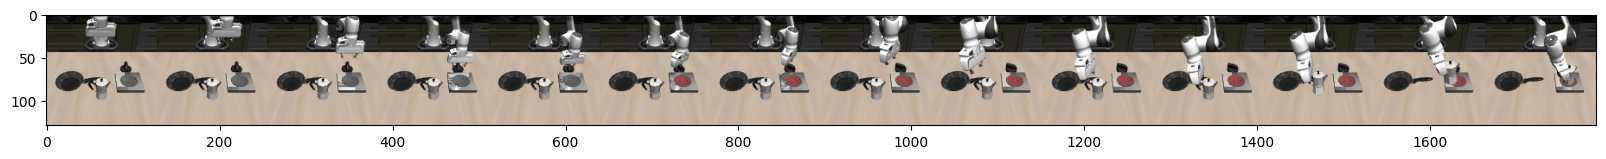

In [148]:
plt.figure(figsize=(20, 2))
img = np.hstack(traj['obs']['agentview_rgb'][::20])  # stack image
img = np.flip(img, 0)



plt.imshow(img)